In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

#pickle files is when serialization is performed on data before writing on disk
# character streams are more convenient to store and transfer with the use of pickles

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline
np.random.seed(0)
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
 
print(type(train_data)) # returns a dictionary

# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.
ls: cannot access 'german-traffic-sign': No such file or directory


Using TensorFlow backend.


<class 'dict'>
(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


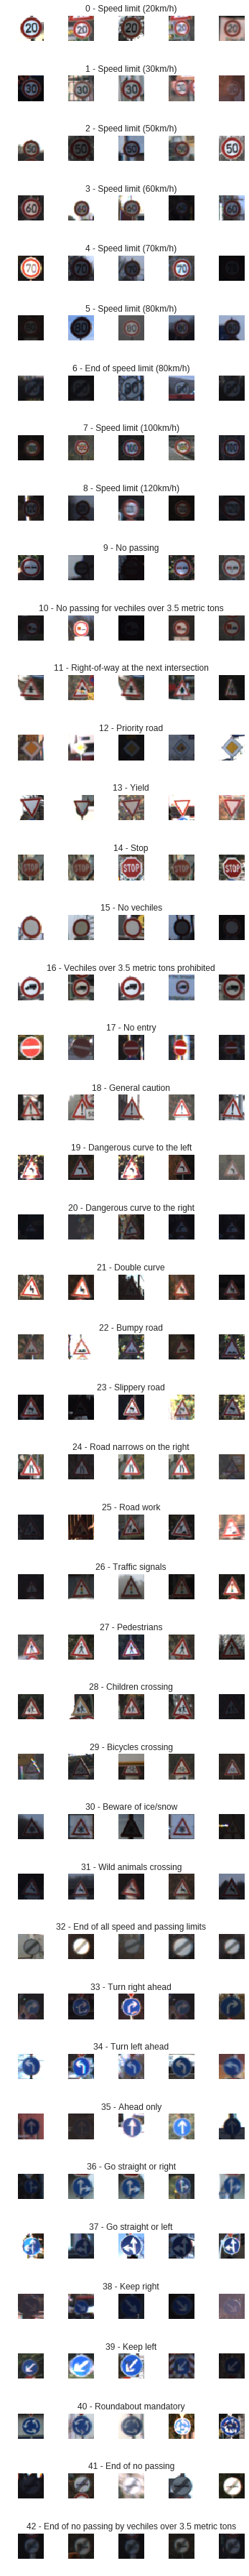

In [2]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)  

num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

#revisit mnsit to see why this is like this
for i in range(cols):
   for j, row in data.iterrows():      
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
         axs[j][i].set_title(str(j) + " - " + row["SignName"])
         num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


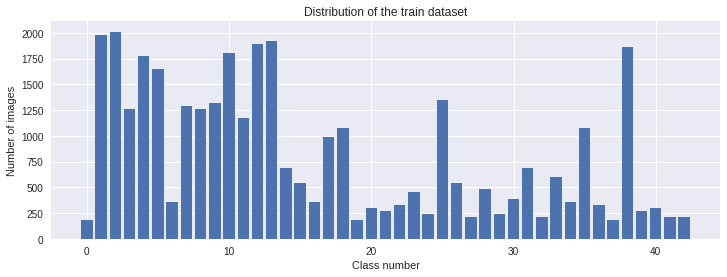

In [3]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


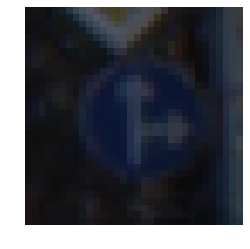

In [4]:
#Preprocess the images
import cv2
 
plt.imshow(X_train[1000]) # plot at the 1000th index
plt.axis("off") #turn off grid lines
print(X_train[1000].shape) #keep track of changes through preprocessing
print(y_train[1000]) #print the label of the image. 
#1) convert to grayscale
#Reduce depth from 3 to 1 for more efficiency 
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)
(34799, 32, 32)


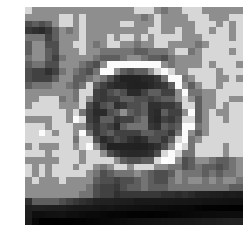

In [5]:

img = grayscale(X_train[1000]) #convert from 3 channel color to grayscale
plt.imshow(img) #show image
plt.axis("off") #remove grids
print(img.shape) #retrieve the shape

#2) Histogram equalization
# standardise the lighting in all the images so that all images have same 
# brightness values. Improves feature extraction. 
def equalize(img):
    img = cv2.equalizeHist(img) #equalize the image
    return img
  
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

#3) preprocess entire dataset by both grayscale and equalization
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 # normalization all images to values between 0 and 1. Check out mnist tut again
    return img

"""
Iterate through entire array
For every element looped through:
  * Return new element based on specified function
To return new array with updated values

-> preprocess is the function, iterate through entire X_train dataset
-> return preprocessed images into the form of a list
"""
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
  
plt.imshow(X_train[random.randint(0, len(X_train) - 1)]) # return random image in the array
plt.axis('off')
print(X_train.shape)

In [0]:
"""
Need to add depth for conv layer
We shape the data according to the shape shown above with a depth of 1 due to 
1 channel present since it is a grayscale image
"""

X_train = X_train.reshape(34799, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


(15, 32, 32, 1)


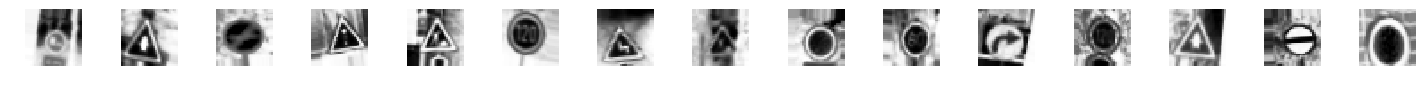

In [7]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [0]:
#One hot encode the image
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)
# create model

"""
Improving model
----------------
increase number of filters
reduce the learning rate(somethimes by a factorf of 10)
Adding extra convolutional layers
Add more dropout layrer
"""
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [9]:
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)                            validation_data=(X_val, y_val), shuffle = 1)

SyntaxError: ignored

In [27]:


print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
print("predicted sign: "+ str(model.predict_classes(img)))

NameError: ignored